In [35]:
# from google.colab import drive
# drive.mount('/content/drive')

In [36]:
# cd /content/drive/MyDrive/gammaAE/Simulation_study

Consider a model

\begin{align}
    Z & \sim p(z)  = 
    t_q(\mathbf{0}_q, D, \nu), \\[2mm]
    X_\theta|Z & \sim p_\theta(x|z) = 
    t_p\left(
        f_\theta(z), 
        \frac{1 + \nu^{-1} z^\intercal D^{-1} z}{1 + \nu^{-1} q} \Lambda, \nu+q 
    \right). 
\end{align}

If $f_\theta(z) = Az + b$, then

\begin{align}
    \begin{bmatrix}
        X_\theta \\ Z 
    \end{bmatrix} 
    & \sim
    t_{p+q} \left(
        \begin{bmatrix}
            b \\ \mathbf{0}_q
        \end{bmatrix}, 
        \begin{bmatrix}
            ADA^\intercal + \Lambda & AD \\
            DA^\intercal             & D
        \end{bmatrix}, 
        \nu
    \right), \\[5mm]
    X_\theta
    & \sim 
    t_p \left(
        b, ADA^\intercal + \Lambda, \nu
    \right)
    \\
    Z|X_\theta 
    & \sim t_q \left(
        DA^\intercal \left(
            ADA^\intercal + \Lambda
        \right)^{-1}(x - b), 
        \frac{\nu + (x-b)^\intercal \left(
            ADA^\intercal + \Lambda
        \right)^{-1} (x-b)}{\nu+p}\left(
            D - DA^\intercal \left(
                ADA^\intercal + \Lambda
            \right)^{-1} AD
        \right), 
        \nu+p
    \right)
\end{align}

If $D = I_q$ and $\Lambda = \sigma^2 I_p$, then 

\begin{align}
    \begin{bmatrix}
        X_\theta \\ Z 
    \end{bmatrix} 
    & \sim
    t_{p+q} \left(
        \begin{bmatrix}
            b \\ \mathbf{0}_q
        \end{bmatrix}, 
        \begin{bmatrix}
            AA^\intercal + \sigma^2 I_p & A \\
            A^\intercal             & I_q
        \end{bmatrix}, 
        \nu
    \right), \\[5mm]
    X_\theta
    & \sim 
    t_p \left(
        b, AA^\intercal + \sigma^2 I_p, \nu
    \right)
    \\
    Z|X_\theta 
    & \sim t_q \left(
        A^\intercal \left(
            AA^\intercal + \sigma^2 I_p
        \right)^{-1}(x - b), 
        \frac{\nu + (x-b)^\intercal \left(
            AA^\intercal + \sigma^2 I_p
        \right)^{-1} (x-b)}{\nu+p}\left(
            I_q - A^\intercal \left(
                AA^\intercal + \sigma^2 I_p
            \right)^{-1} A
        \right), 
        \nu+p
    \right)
\end{align}

In [37]:
import random
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from simul_util import make_reproducibility, sampling, simulation, MYTensorDataset
from simul_loss import log_t_normalizing_const, gamma_regularizer
from simul_model import Encoder, Decoder, gammaAE
from simul_shallow import Shallow_Encoder, Shallow_Decoder, Shallow_gammaAE

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device(f'cuda:0' if USE_CUDA else "cpu")

index = 103
p_dim = 2
q_dim = 1
nu = 10
nu_sample = 5
epochs = 50
num_layers = 128
recon_sigma = 0.25
sample_N = 5000
batch_size = 128
make_reproducibility(1000)
module_type = gammaAE


A = torch.randn(p_dim, q_dim)
b = torch.randn(p_dim)

t_sample = simulation(
    DEVICE, p_dim=p_dim, SEED=1500,
    K=1, N_list=[sample_N],
    mu_list=[b],
    var_list=[recon_sigma**2 * torch.eye(p_dim) + A @ A.T],
    nu_list=[nu_sample]
)

normal_sample = simulation(
    DEVICE, p_dim=p_dim, SEED=1500,
    K=1, N_list=[sample_N],
    mu_list=[b],
    var_list=[recon_sigma**2 * torch.eye(p_dim) + A @ A.T],
    nu_list=[0]
)

simulation_trainset = MYTensorDataset(t_sample)
contrast_trainset = MYTensorDataset(normal_sample)


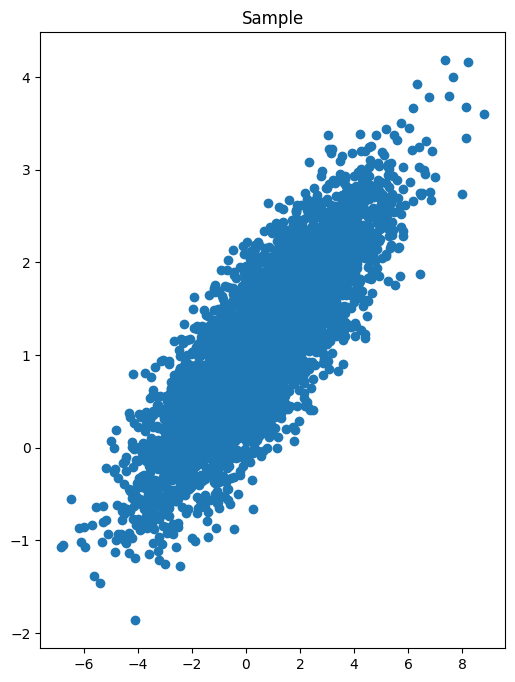

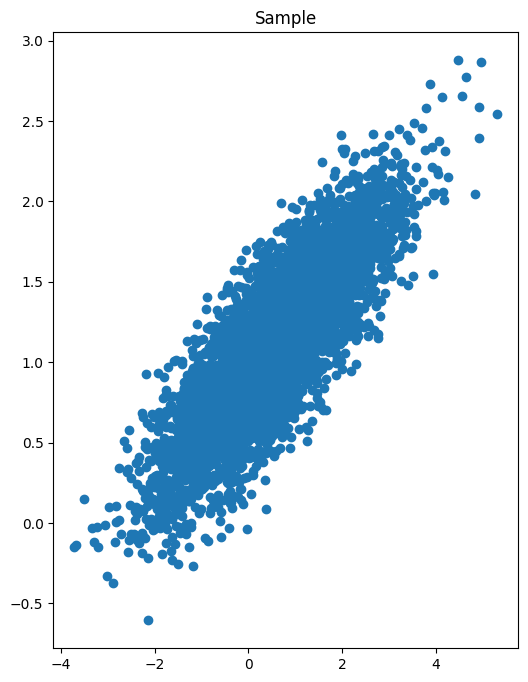

In [38]:
import matplotlib.pyplot as plt
from simul_visualize import visualize_2D, visualize_3D, total_visualize_2D, total_visualize_3D


# visualize_3D(t_sample).show()
visualize_2D(t_sample).show()
visualize_2D(normal_sample).show()

In [39]:
# MVT_true_recon = [(A @ x + b).reshape(1,2) for x in MVT_prior]
# visualize_2D(torch.cat(MVT_true_recon)).show()

In [40]:


# gAE = Shallow_gammaAE(simulation_trainset, p_dim, q_dim, nu, DEVICE, num_layers = num_layers, recon_sigma = recon_sigma, batch_size = batch_size)
# VAE = Shallow_gammaAE(simulation_trainset, p_dim, q_dim, 0 , DEVICE, num_layers = num_layers, recon_sigma = recon_sigma, batch_size = batch_size)
gAE = module_type(simulation_trainset, p_dim, q_dim, nu, DEVICE, num_layers = num_layers, recon_sigma = recon_sigma, batch_size = batch_size)
VAE = module_type(simulation_trainset, p_dim, q_dim, 0 , DEVICE, num_layers = num_layers, recon_sigma = recon_sigma, batch_size = batch_size)



epoch_tqdm = tqdm(range(0, epochs))
for epoch in epoch_tqdm : 
    # print(f'\nEpoch {epoch}')
    gAE.train(epoch)
    VAE.train(epoch)

100%|██████████| 50/50 [00:23<00:00,  2.13it/s]


In [41]:
# print(gAE.decoder.fc.weight)
# print(A)

# print(gAE.decoder.fc.bias)
# print(b)

# print(gAE.encoder.latent_mu.weight)
# print(A.T @ torch.linalg.inv(A @ A.T + recon_sigma**2 * torch.eye(p_dim)))

# print(gAE.encoder.latent_mu.bias)
# print(A.T @ torch.linalg.inv(A @ A.T + recon_sigma**2 * torch.eye(p_dim)) @ b)



In [42]:
MVT_prior = sampling(sample_N, torch.zeros(q_dim), torch.eye(q_dim), nu, DEVICE)
MVN_prior = sampling(sample_N, torch.zeros(q_dim), torch.eye(q_dim), 0, DEVICE)

gAE_reconstruction = gAE.decoder.sampling(gAE.encoder(t_sample)[0]).detach().cpu().numpy()
VAE_reconstruction = VAE.decoder.sampling(VAE.encoder(t_sample)[0]).detach().cpu().numpy()

gAE_sample = gAE.decoder.sampling(MVT_prior).detach().cpu().numpy()
VAE_sample = VAE.decoder.sampling(MVN_prior).detach().cpu().numpy()

std: torch.Size([5000, 2])
v: tensor([12.4386], device='cuda:0')
const: tensor([[-0.4097, -0.1553],
        [ 0.0720,  0.1513],
        [ 0.2579,  0.2779],
        ...,
        [ 0.0542, -0.1848],
        [ 0.0201, -0.2108],
        [ 0.1161, -0.2347]], device='cuda:0', grad_fn=<MulBackward0>)
std: torch.Size([5000, 2])
v: tensor([14.6593], device='cuda:0')
const: tensor([[-0.0876, -0.2719],
        [ 0.1628, -0.2484],
        [-0.1324, -0.0531],
        ...,
        [-0.1206,  0.1282],
        [ 0.2543, -0.0690],
        [-0.2150, -0.1148]], device='cuda:0')


In [43]:
# x_sample = sampling(1000, torch.zeros(p_dim), torch.eye(p_dim), 0, DEVICE)
# var_recon = torch.exp(gAE.encoder.latent_var(x_sample))


# def true_var(x, p_dim, q_dim, A, b, nu, recon_sigma) : 
#     term1 = (nu + (x - b).T @ torch.linalg.inv(A @ A.T + recon_sigma**2 * torch.eye(p_dim)) @ (x - b)) / (nu + p_dim)
#     term2 = torch.eye(q_dim) - A.T @ torch.linalg.inv(A @ A.T + recon_sigma**2 * torch.eye(p_dim)) @ A
#     return term1 * term2

# true_var_list = [
#     true_var(x.cpu(), p_dim, q_dim, A, b, nu, recon_sigma) for x in x_sample
# ]
# torch.as_tensor(true_var_list).unsqueeze(1).shape
# torch.cat([x_sample, torch.as_tensor(true_var_list).to(DEVICE).unsqueeze(1)], axis = 1)

# visualize_3D(torch.cat([x_sample, var_recon], axis = 1).detach()).show()

# visualize_3D(torch.cat([x_sample, torch.as_tensor(true_var_list).to(DEVICE).unsqueeze(1)], axis = 1).detach()).show()


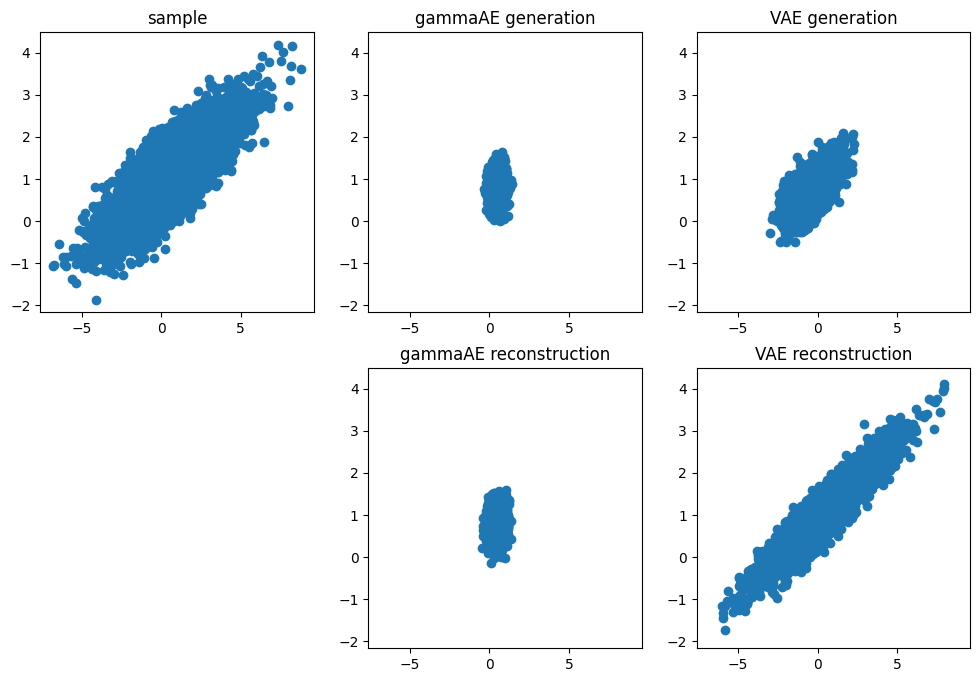

In [44]:
total_visualize_2D(t_sample, gAE_reconstruction, gAE_sample, 
                   VAE_reconstruction, VAE_sample).show()
# total_visualize_3D(t_sample, gAE_reconstruction, gAE_sample, 
#                    VAE_reconstruction, VAE_sample).show()

In [45]:
# import pandas as pd

# pd.DataFrame(normal_sample).to_csv(f'n_sample_{index}.csv', index = False)
# pd.DataFrame(t_sample).to_csv(f't_sample_{index}.csv', index = False)
# pd.DataFrame(gAE_reconstruction).to_csv(f'gAE_recon_{index}.csv', index = False)
# pd.DataFrame(VAE_reconstruction).to_csv(f'VAE_recon_{index}.csv', index = False)
# pd.DataFrame(gAE_sample).to_csv(f'gAE_gen_{index}.csv', index = False)
# pd.DataFrame(VAE_sample).to_csv(f'VAE_gen_{index}.csv', index = False)